In [4]:
import folium
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import rasterio.plot as plot

from folium.plugins import MousePosition
from rasterio import warp, windows




In [5]:
path_in = '/media/ggarcia/data/Satellogic/Satellogic/Tests/GitHubTest/Plotly-Folium-test/folium/data/'
name_in = '2017_09_30_S2_RGB.tif'

name_product = 'Sentinel-2'


Window(col_off=0, row_off=0, width=1375, height=1863)
(1863, 1375, 3)


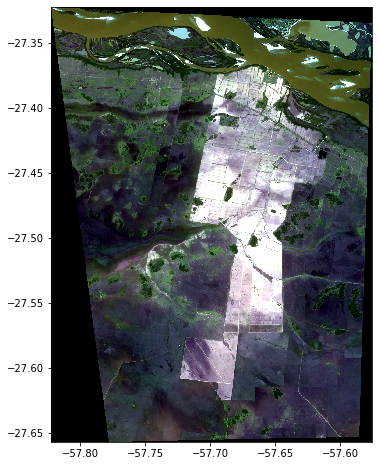

In [6]:
### read raster file
src = rasterio.open(path_in + name_in)

slice_ = (slice(0,src.height),slice(0,src.width))
window_slice = windows.Window.from_slices(*slice_)
print(window_slice)

bbox = windows.bounds(window_slice,src.transform)


# find specific transform, necessary to show the coordinates appropiately
transform_window = windows.transform(window_slice,src.transform)

# Read img and convert to rgb
img = np.stack([src.read(4-i,) for i in range(1,4)],
            axis=-1)

print(img.shape)
plt.figure(figsize=(8,8))
plot.show(img.transpose(2,0,1),
        transform=transform_window, )





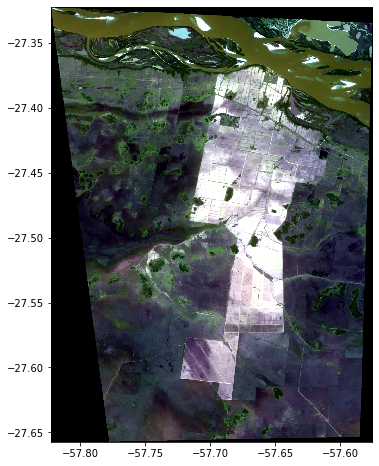

In [7]:
transform,width,height = warp.calculate_default_transform(src.crs, {"init":"epsg:4326"},
                                                             img.shape[1],img.shape[0],
                                                             left=bbox[0],bottom=bbox[1],
                                                             right=bbox[2],top=bbox[3],
                                                             resolution=0.0002)

out_array = np.ndarray((img.shape[2],height,width),dtype=img.dtype)

warp.reproject(np.transpose(img,axes=(2,0,1)),
               out_array,src_crs=src.crs,dst_crs={"init":"epsg:4326"},
               src_transform=transform_window,
               dst_transform=transform,resampling=warp.Resampling.bilinear)

bounds_trans = warp.transform_bounds(src.crs,{'init': 'epsg:4326'},*bbox)
    
plt.figure(figsize=(10,8))
plot.show(out_array,
          transform=transform)

In [8]:
### define the world map centered around center of tif image
    
mean_lat = (bbox[1] + bbox[3]) / 2.0
mean_lng = (bbox[0] + bbox[2]) / 2.0
    
map_bb = folium.Map(location=[mean_lat,mean_lng], zoom_start=8)
    
folium.TileLayer('cartodbpositron').add_to(map_bb)
    
folium.raster_layers.TileLayer(
    tiles='http://{s}.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
    attr='google',
    name='google maps',
    max_zoom=20,
    subdomains=['mt0', 'mt1', 'mt2', 'mt3'],
    overlay=False,
    control=True,
).add_to(map_bb)
    
folium.raster_layers.TileLayer(
    tiles='http://{s}.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',
    attr='google',
    name='google street view',
    max_zoom=20,
    subdomains=['mt0', 'mt1', 'mt2', 'mt3'],
    overlay=False,
    control=True,
).add_to(map_bb)
    
image_overlay = folium.raster_layers.ImageOverlay(np.transpose(out_array,(1,2,0)),
                                                  [[bounds_trans[1],
                                                    bounds_trans[0]],
                                                    [bounds_trans[3],
                                                    bounds_trans[2]]],
                                                    name="Sentinel-2")
map_bb.add_child(image_overlay)
folium.map.LayerControl(position='topright').add_to(map_bb)
    
### add mouse position
MousePosition().add_to(map_bb)

map_bb